# 1D Burgers' equation, finite volume, reconstructed upwind scheme

_Gilbert François Duivesteijn_

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.integrate import odeint
from scipy.linalg import toeplitz

from IPython import display

Burgers' equation or Bateman–Burgers equation is a fundamental partial differential equation occurring in various areas of applied mathematics, such as fluid mechanics, nonlinear acoustics, gas dynamics, and traffic flow. The equation was first introduced by Harry Bateman in 1915 and later studied by Johannes Martinus Burgers in 1948 [1].

For a given field $u(x,t)$ and diffusion coefficient (or kinematic viscosity, as in the original fluid mechanical context) $\nu$ , the general form of Burgers' equation (also known as viscous Burgers' equation) in one space dimension is the dissipative system:

\begin{align}
\frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} &= \nu\frac{\partial^2 u}{\partial x^2} .\\
\end{align}

When the diffusion term is absent (i.e. $\nu=0$), Burgers' equation becomes the inviscid Burgers' equation:

\begin{align}
\frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} &= 0 .\\
\end{align}

With $f(u) = \frac{u^2}{2}$ and applying the chain rule, we can write this non-linear equation, known as the Burgers' equation as

\begin{align}
\frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial u} \frac{\partial u}{\partial x} &= 0 \\
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} &= 0. \\
\end{align}

where $\frac{\partial f(u)}{\partial u}$ can be seen as the local wave speed.


Writing the Burgers' equation in integral form
\begin{align}
\int_{a}^{b} \left( \frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} \right)dx &= 0 \\
\frac{d}{dt} \int_{a}^{b} udx + \left. f(u) \right|_a^b &= 0
\end{align}

Bringing the $f(u)$ term to the other side
\begin{align}\label{eq:burgers_int}
\frac{d}{dt} \int_{a}^{b} udx &= f(u(a)) - f(u(b))
\end{align}

Now, $f(u(b)) - f(u(a))$ can be seen as the flux. 

For example if $u$ is denoted as the density, then the integral of $u$ over the spacial domain $\int_{a}^{b} udx$ means the total amount of mass inside this range and $\frac{d}{dt}$ is the rate of change.

In words the integral form of the Burgers' equation (\ref{eq:burgers_int}) can be described as:

>The rate of change of mass inside a volume is equal to the rate of flux going into the volume minus the rate of flux going out of the volume.

Substituting $f(u) = \frac{u^2}{2}$ into (\ref{eq:burgers_int}) gives

\begin{align}\label{eq:burgers_int2}
\frac{d}{dt} \int_{a}^{b} udx + \frac{u(b)^2}{2} - \frac{u(a)^2}{2} &= 0
\end{align}

[1] [Burgers' equation](https://en.wikipedia.org/wiki/Burgers%27_equation)

## Upwind flux scheme

```
  +------+------+------+------+------+--/ /-+------+------+------+------+
  |  U0  |  U1  |      |      |      |  \ \ |      |      |      |  Un  |
  |      |      |      |      |      |  / / |      |      |      |      |
  +------+------+------+------+------+--\ \-+------+------+------+------+
  :  i=0 :  i=1                                            i=n-1    i=n
  :      :
  :      :
i-1/2  i+1/2    
```

For the 1D case, when denoting the cells as $i$ from $0$ to $n$, the cell boundaries on the left and right hand side are denoted as $i-\frac{1}{2}$ and $i+\frac{1}{2}$. The state $u_i$ is the average of $\bar{u}$ inside a volume, defined by

\begin{align}
\bar{u_i} &= \frac{1}{\Delta x}\int_{i-\frac{1}{2}}^{i_\frac{1}{2}} u dx \\
\end{align}


Now we can write e.g. the flux of the left and right boundary of cell $i$ as
\begin{align}
f_{i-\frac{1}{2}} = \frac{f_i + f_{i-1}}{2} \\
f_{i+\frac{1}{2}} = \frac{f_i + f_{i+1}}{2}
\end{align}
where $f_i = f(\bar{u_i})$ and $\bar{u_i}$ = the average value of u in cell $i$.

The equation to solve is

\begin{align}
\frac{\partial \bar{u_i}}{\partial t} = \frac{f_{i-\frac{1}{2}}  - f_{i+\frac{1}{2}}}{\Delta x}
\end{align}

Now, instead of taking the central average around a cell boundary, we take the flux from the upwind direction only. To compute the shock speed at the cell center, we do

\begin{align}
s_{i+\frac{1}{2}} = \frac{u_i + u_{i+1}}{2}
\end{align}

The flux at boundary $i+\frac{1}{2}$ becomes

\begin{align}
f_{i+\frac{1}{2}} = 
\left\{ 
\begin{array}{l l l}
f_i & \textrm{where} & s_{i+\frac{1}{2}} > 0, \\
f_{i+1} & \textrm{where} & s_{i+\frac{1}{2}} < 0,
\end{array}
\right.
\end{align}


_Note that with the upwind schema, the solution is **stable**, when a shock wave appears._

# Godunov scheme

```
--------------------+--------------------
                    |
        u_i         |         u_i+1
                    |
                  L | R
            u_i+1/2 | u_i+1/2
                    |
--------------------+--------------------
```

For 1st order 

In [3]:
# number of cells in 1D space
n = 100
u = np.zeros(shape=(n,))

# space
x0 = 0
xn = 1
dx = (xn - x0)/n
x_interface = np.linspace(x0, xn, n+1)
x = x_interface[0:n] + dx/2

# time
t0 = 0
tn = .5
t_steps = 200
t = np.linspace(t0, tn, t_steps)


# Initial condition
u_init = np.sin(2*np.pi*x)
#u_init[n//2:] = 0.5*(x[n//2:]+.2)

In [4]:
def limiter(r):
    # set all r < 0 to 0, also to prevent division by 0 for r = -1
    _r = r.copy()
    _r[_r < 0] = 0
    # Van Leer limiter
    phi = 2*_r/(1 + _r)
    phi[~np.isfinite(_r)] = 0
    return phi

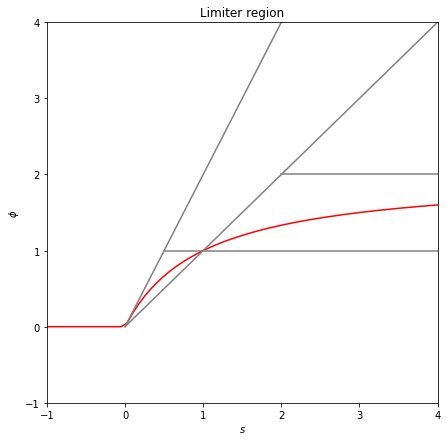

In [15]:

xl0 = np.linspace(2, 10, 201)
yl0 = np.ones(201)*2

xl1 = np.linspace(0, 10, 201)
yl1 = 1*xl1

xl2 = np.linspace(0, 10, 201)
yl2 = 2*xl2

xl3 = np.linspace(0.5, 10, 201)
yl3 = np.ones(201)

_r = np.linspace(-5, 10, 201)
_phi = limiter(_r)
plt.figure(figsize=(7,7))
plt.plot(_r, _phi, c="red")
plt.plot(xl0, yl0, c="gray")
plt.plot(xl1, yl1, c="gray")
plt.plot(xl2, yl2, c="gray")
plt.plot(xl3, yl3, c="gray")
plt.xlim([-1, 4])
plt.ylim([-1,4])
plt.title("Limiter region")
plt.xlabel("$s$")
plt.ylabel("$\phi$")
plt.show()

In [6]:
def godunov(ul, ur):
    # Burgers flux
    fL = ul**2 / 2
    fR = ur**2 / 2
    f_min = 0
    f = np.zeros_like(ul)
    # Flux goes to the right
    f[ul > ur] = np.maximum(fL[ul > ur], fR[ul > ur])
    # Flux goes to the left
    f[ul <= ur] = np.minimum(fL[ul <= ur], fR[ul <= ur])
    # Minimum flux at u* 
    f[np.where((ul <= 0) & (ur > 0))] = f_min
    return f

In [7]:
# TEST Godunov function.

ul = np.array([1.1, -1.2, 1.3, 1.4, -1.5, 2.6, -2.7])
ur = np.array([1.1,  1.2,-1.3, 2.4, -2.5, 1.6, -1.7])

f_pred = godunov(ul, ur)
f_true = np.array([0.6050, 0, 0.8450, 0.9800, 3.1250, 3.3800, 1.4450])

assert np.allclose(f_pred, f_true, atol=1e-4)

In [8]:
def dudt(u, t, dx):
    n = len(u)

    # u denotes state in cell centers (in the formulas sometimes written as \bar{u})
    # f denotes f(u) in cell centers, using Burgers' equation f(u) = u^2/2    
    u_im1 = np.hstack([0, u[0: n-1]])
    u_ip1 = np.hstack([u[1:n], 0])
    u_ip2 = np.hstack([u_ip1[1:n], 0])

    assert len(u) == n
    assert len(u_im1) == n
    assert len(u_ip1) == n
    assert len(u_ip2) == n
    assert u_im1[1] == u[0]
    assert u_ip1[1] == u[2]
    assert u_ip2[1] == u[3]
    
    # Reconstruct u_i_plus_half_left
    r = (u_ip1 - u)/(u - u_im1)
    phi = limiter(r)
    u_iph_left = u + 0.5*(u - u_im1)*phi
    
    # Reconstruct u_i_plus_half_right
    r = (u - u_ip1)/(u_ip1 - u_ip2)
    phi = limiter(r)
    u_iph_right = u_ip1 + 0.5*(u_ip1 - u_ip2)*phi
    
    f_interface = godunov(u_iph_left, u_iph_right)
    f_interface = np.hstack([0, f_interface])

    du_dt = (f_interface[0:n] - f_interface[1:n+1])/dx
    return du_dt


In [9]:
# TEST dudt Burgers' function

_xtest = np.linspace(0, 1, 11)
_utest = np.sin(2*np.pi*_xtest)
y_pred = dudt(_utest, None, 1/len(_xtest))
y_true = np.array([0, -3.6291, -1.3457, 0, 4.2490, 0.0000, -4.2490, -0.0000, 1.3457, 3.6291, 0.0000])

assert np.allclose(y_pred, y_true, atol=1e-4)


/tmp/ipykernel_29922/124400543.py:19: RuntimeWarning: divide by zero encountered in true_divide
  r = (u_ip1 - u)/(u - u_im1)
/tmp/ipykernel_29922/1253491892.py:6: RuntimeWarning: invalid value encountered in true_divide
  phi = 2*_r/(1 + _r)
/tmp/ipykernel_29922/124400543.py:24: RuntimeWarning: divide by zero encountered in true_divide
  r = (u - u_ip1)/(u_ip1 - u_ip2)


In [10]:
u = odeint(dudt, u_init, t, args=(dx,))

# There will be some divisions by zero because of the rate r and the computation of the Van Leer flux limiter,
# but we have it under control.

/tmp/ipykernel_29922/124400543.py:19: RuntimeWarning: divide by zero encountered in true_divide
  r = (u_ip1 - u)/(u - u_im1)
/tmp/ipykernel_29922/1253491892.py:6: RuntimeWarning: invalid value encountered in true_divide
  phi = 2*_r/(1 + _r)
/tmp/ipykernel_29922/124400543.py:24: RuntimeWarning: divide by zero encountered in true_divide
  r = (u - u_ip1)/(u_ip1 - u_ip2)


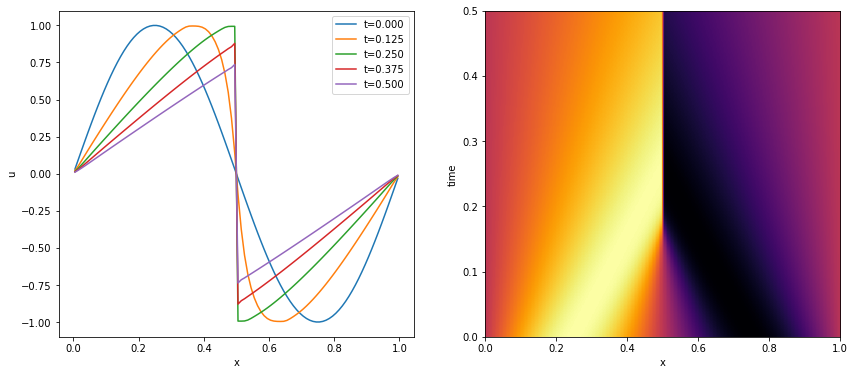

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
#axs[0].set_ylim(min(U0, Un),max(U0,Un))
axs[0].plot(x, u[0], label=f"t={0/t_steps*(tn-t0):.3f}")
axs[0].plot(x, u[49], label=f"t={50/t_steps*(tn-t0):.3f}")
axs[0].plot(x, u[99], label=f"t={100/t_steps*(tn-t0):.3f}")
axs[0].plot(x, u[149], label=f"t={150/t_steps*(tn-t0):.3f}")
axs[0].plot(x, u[199], label=f"t={200/t_steps*(tn-t0):.3f}")
axs[0].legend()
axs[0].set_ylabel("u")
axs[0].set_xlabel("x")
axs[1].imshow(u, aspect="auto", cmap="inferno", origin="lower", extent=[0, 1, t0, tn])
axs[1].set_xlabel(f"x")
axs[1].set_ylabel("time")
plt.show()

In [12]:
# Animation of the solution over the integrated time span.

def animate(frame):
    y = u[frame]
    line.set_data((x, y))
    plt.title(f"t={tn * frame / t_steps:0.2f}")

    
fig = plt.figure(figsize=(6, 6))
lines = plt.plot([])
line = lines[0]
plt.xlim([x0, xn])
plt.ylim([-1.1, 1.1])
plt.xlabel("x")
plt.ylabel("u")
plt.title("")
  
anim = FuncAnimation(fig, animate, frames=t_steps, interval=50)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

In [13]:
np.max(u[-1])

0.7365118655083266